In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("train.csv", index_col=0)
print(df.columns)
df = df.drop(["Cabin","Name","Ticket"], axis=1)
df

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S
889,0,3,female,NaN,1,2,23.4500,S


In [3]:
df1 = df["Sex"]
df_dummy = pd.get_dummies(df1,drop_first=True)
df["Sex_M"] = df_dummy #Male is one
df = df.drop(columns=["Sex"])
df

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_M
PassengerId,,,,,,,,
1,0,3,22.0,1,0,7.2500,S,1
2,1,1,38.0,1,0,71.2833,C,0
3,1,3,26.0,0,0,7.9250,S,0
4,1,1,35.0,1,0,53.1000,S,0
5,0,3,35.0,0,0,8.0500,S,1
...,...,...,...,...,...,...,...,...
887,0,2,27.0,0,0,13.0000,S,1
888,1,1,19.0,0,0,30.0000,S,0
889,0,3,NaN,1,2,23.4500,S,0


In [4]:
df.isnull().sum()

Survived      0
Pclass        0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Sex_M         0
dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder
df = df.apply(lambda col: LabelEncoder().fit_transform(df["Embarked"]) if col.dtype == "object" else col)
df.head(15)

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_M
PassengerId,,,,,,,,
1,0,3,22.0,1,0,7.2500,2,1
2,1,1,38.0,1,0,71.2833,0,0
3,1,3,26.0,0,0,7.9250,2,0
4,1,1,35.0,1,0,53.1000,2,0
5,0,3,35.0,0,0,8.0500,2,1
6,0,3,NaN,0,0,8.4583,1,1
7,0,1,54.0,0,0,51.8625,2,1
8,0,3,2.0,3,1,21.0750,2,1
9,1,3,27.0,0,2,11.1333,2,0


In [6]:
df.isnull().sum()

Survived      0
Pclass        0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
Sex_M         0
dtype: int64

In [7]:
# iterative imputation transform for the horse colic dataset
from numpy import isnan, mean, std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold 
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
# load dataset
# split into input and output elements
data = df.values
ix = [i for i in range(data.shape[1]) if i != 9]
X, y = data[:, ix], data[:, 7]
# print total missing
print('Missing: %d' % sum(isnan(X).flatten()))
# define imputer
imputer = IterativeImputer()
#define modeling pipeline
## model = svm.SVC(kernel='rbf', degree =3, gamma = 0.01, C = 100, max_iter=-1, random_state = 262)
model = XGBClassifier(use_label_encoder=False, base_score=0.25, booster='gbtree', eta=0.3, max_depth=4, min_child_weight=20,
                    max_delta_step=0.5, subsample=0.6, colsample_bytree=1, colsample_bylevel=0.7, colsample_bynode=1, 
                    reg_lambda=1, reg_alpha=1, tree_method="approx", sketch_eps=0.1, scale_pos_weight=1.6, 
                    objective="binary:logitraw", gamma=0, n_estimators=10, rate_drop="0.01", skip_drop="0.8",
                    random_state = 262)
# fit on the dataset
imputer.fit(X)
# transform the dataset
df = imputer.transform(X)
# print total missing
print('Missing: %d' % sum(isnan(df).flatten()))
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Missing: 177
Missing: 0
Mean Accuracy: 1.000 (0.000)


In [ ]:
#KNN imputer
from numpy import isnan
from sklearn.impute import KNNImputer
# split into input and output elements
data = df.values
ix = [i for i in range(data.shape[1]) if i != 9]
X, y = data[:, ix], data[:, 7]
# print total missing
print('Missing: %d' % sum(isnan(X).flatten()))
# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X)
# transform the dataset
df = imputer.transform(X)
# print total missing
print('Missing: %d' % sum(isnan(df).flatten()))


In [8]:
df = pd.DataFrame(df)
df.columns = ["Survived","Pclass","Age","SibSp","Parch","Fare","Embarked","Sex_M"]
df

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_M
0,0.0,3.0,22.000000,1.0,0.0,7.2500,2.0,1.0
1,1.0,1.0,38.000000,1.0,0.0,71.2833,0.0,0.0
2,1.0,3.0,26.000000,0.0,0.0,7.9250,2.0,0.0
3,1.0,1.0,35.000000,1.0,0.0,53.1000,2.0,0.0
4,0.0,3.0,35.000000,0.0,0.0,8.0500,2.0,1.0
...,...,...,...,...,...,...,...,...
886,0.0,2.0,27.000000,0.0,0.0,13.0000,2.0,1.0
887,1.0,1.0,19.000000,0.0,0.0,30.0000,2.0,0.0
888,0.0,3.0,23.388746,1.0,2.0,23.4500,2.0,0.0
889,1.0,1.0,26.000000,0.0,0.0,30.0000,0.0,1.0


In [9]:
df.isnull().sum()

Survived    0
Pclass      0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Sex_M       0
dtype: int64

In [10]:
X = df[["Pclass","Age","Fare","Embarked","Sex_M"]]
X

,Pclass,Age,Fare,Embarked,Sex_M
0,3.0,22.000000,7.2500,2.0,1.0
1,1.0,38.000000,71.2833,0.0,0.0
2,3.0,26.000000,7.9250,2.0,0.0
3,1.0,35.000000,53.1000,2.0,0.0
4,3.0,35.000000,8.0500,2.0,1.0
...,...,...,...,...,...
886,2.0,27.000000,13.0000,2.0,1.0
887,1.0,19.000000,30.0000,2.0,0.0
888,3.0,23.388746,23.4500,2.0,0.0
889,1.0,26.000000,30.0000,0.0,1.0


In [11]:
y = df[["Survived"]]
y

,Survived
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
886,0.0
887,1.0
888,0.0
889,1.0


In [12]:
from sklearn.model_selection import train_test_split
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=262)
X_train

,Pclass,Age,Fare,Embarked,Sex_M
259,2.0,50.0,26.0000,2.0,0.0
123,2.0,32.5,13.0000,2.0,0.0
452,1.0,30.0,27.7500,0.0,1.0
642,3.0,2.0,27.9000,2.0,0.0
336,1.0,29.0,66.6000,2.0,1.0
...,...,...,...,...,...
339,1.0,45.0,35.5000,2.0,1.0
591,1.0,52.0,78.2667,0.0,0.0
558,1.0,39.0,79.6500,2.0,0.0
854,2.0,44.0,26.0000,2.0,0.0


In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mmsc = MinMaxScaler(feature_range=(0, 2))
sc = StandardScaler()
X_train = mmsc.fit_transform(X_train)
X_test = mmsc.transform(X_test)
X_test

array([[2.        , 0.51575524, 0.03093714, 1.33333333, 0.        ],
       [2.        , 0.4921958 , 0.0359796 , 1.33333333, 2.        ],
       [2.        , 0.72779021, 0.05642544, 0.        , 2.        ],
       [2.        , 0.78538307, 0.06050797, 0.66666667, 2.        ],
       [2.        , 0.        , 0.27150512, 1.33333333, 2.        ],
       [1.        , 0.65711189, 0.04098927, 1.33333333, 2.        ],
       [2.        , 0.68067133, 0.06285021, 1.33333333, 2.        ],
       [0.        , 1.29321678, 0.11208614, 0.        , 0.        ],
       [2.        , 0.65711189, 0.036012  , 1.33333333, 2.        ],
       [2.        , 0.80492188, 0.02947324, 1.33333333, 2.        ],
       [1.        , 1.1283007 , 0.10247318, 1.33333333, 2.        ],
       [2.        , 0.20948252, 0.12208947, 1.33333333, 2.        ],
       [2.        , 0.79846853, 0.03074195, 1.33333333, 2.        ],
       [0.        , 1.10474126, 0.20299448, 1.33333333, 2.        ],
       [2.        , 0.56287413, 0.

In [14]:
import tensorflow as tf
import keras
tf.__version__

'2.6.0'

In [169]:
from keras.layers import Dropout
### Initializing the ANN
ann = tf.keras.models.Sequential()
### Adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=14, activation='relu'))
ann.add(tf.keras.layers.Dense(units=14, activation='relu'))
ann.add(tf.keras.layers.Dense(units=14, activation='relu'))
ann.add(Dropout(0.2))
ann.add(tf.keras.layers.Dense(units=7, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
### Compiling the ANN
ann.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])
### Training the ANN on the Training set
ann.fit(X_train, y_train, batch_size = 10, epochs = 200)

Epoch 1/200
76/76 [==============================] - 0s 745us/step - loss: 0.6870 - accuracy: 0.6618
Epoch 2/200
76/76 [==============================] - 0s 745us/step - loss: 0.6728 - accuracy: 0.6975
Epoch 3/200
76/76 [==============================] - 0s 811us/step - loss: 0.6626 - accuracy: 0.7041
Epoch 4/200
76/76 [==============================] - 0s 811us/step - loss: 0.6485 - accuracy: 0.7094
Epoch 5/200
76/76 [==============================] - 0s 758us/step - loss: 0.6308 - accuracy: 0.7437
Epoch 6/200
76/76 [==============================] - 0s 745us/step - loss: 0.6109 - accuracy: 0.78070s - loss: 0.6142 - accuracy: 0.77
Epoch 7/200
76/76 [==============================] - 0s 731us/step - loss: 0.5913 - accuracy: 0.7701
Epoch 8/200
76/76 [==============================] - 0s 785us/step - loss: 0.5709 - accuracy: 0.78340s - loss: 0.5676 - accuracy: 0.78
Epoch 9/200
76/76 [==============================] - 0s 811us/step - loss: 0.5533 - accuracy: 0.7701
Epoch 10/200
76/76 [===

76/76 [==============================] - 0s 785us/step - loss: 0.4590 - accuracy: 0.7966
Epoch 81/200
76/76 [==============================] - 0s 798us/step - loss: 0.4476 - accuracy: 0.8058
Epoch 82/200
76/76 [==============================] - 0s 824us/step - loss: 0.4413 - accuracy: 0.8058
Epoch 83/200
76/76 [==============================] - 0s 864us/step - loss: 0.4465 - accuracy: 0.8018
Epoch 84/200
76/76 [==============================] - 0s 891us/step - loss: 0.4471 - accuracy: 0.7979
Epoch 85/200
76/76 [==============================] - 0s 788us/step - loss: 0.4430 - accuracy: 0.8071
Epoch 86/200
76/76 [==============================] - 0s 797us/step - loss: 0.4527 - accuracy: 0.8071
Epoch 87/200
76/76 [==============================] - 0s 771us/step - loss: 0.4530 - accuracy: 0.8098
Epoch 88/200
76/76 [==============================] - 0s 878us/step - loss: 0.4450 - accuracy: 0.80710s - loss: 0.4360 - accuracy: 0.81
Epoch 89/200
76/76 [==============================] - ETA: 0s

In [170]:
from sklearn.metrics import average_precision_score
y_pred_train = np.round(ann.predict(X_train),0)
y_pred_test = np.round(ann.predict(X_test),0)
precision_test = average_precision_score(y_test, y_pred_test)
precision_train = average_precision_score(y_train, y_pred_train)
print(precision_train)
print(precision_test)

0.691440565198004
0.6113063781178213


In [171]:
from sklearn.metrics import f1_score
f1_train = f1_score(y_train, y_pred_train, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')
print(f1_train)
print(f1_test)

0.7849940828402366
0.7873015873015872


In [55]:
### Initializing the ANN
ann_p = tf.keras.models.Sequential()
### Adding the input layer and the first hidden layer
ann_p.add(tf.keras.layers.Dense(units=16, activation='elu'))
ann_p.add(tf.keras.layers.Dense(units=16, activation='elu'))
ann_p.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
### Compiling the ANN
ann_p.compile(optimizer = 'RMSprop', loss = 'poisson', metrics = ['accuracy'])
### Training the ANN on the Training set
ann_p.fit(X_train, y_train, batch_size = 8, epochs = 250)

Epoch 1/250
95/95 [==============================] - 1s 944us/step - loss: 0.7170 - accuracy: 0.6869
Epoch 2/250
95/95 [==============================] - 0s 721us/step - loss: 0.6906 - accuracy: 0.7358
Epoch 3/250
95/95 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.78 - 0s 753us/step - loss: 0.6771 - accuracy: 0.7807
Epoch 4/250
95/95 [==============================] - 0s 732us/step - loss: 0.6698 - accuracy: 0.7754
Epoch 5/250
95/95 [==============================] - 0s 775us/step - loss: 0.6648 - accuracy: 0.7847
Epoch 6/250
95/95 [==============================] - 0s 764us/step - loss: 0.6630 - accuracy: 0.7701
Epoch 7/250
95/95 [==============================] - 0s 700us/step - loss: 0.6607 - accuracy: 0.7728
Epoch 8/250
95/95 [==============================] - 0s 764us/step - loss: 0.6602 - accuracy: 0.7847
Epoch 9/250
95/95 [==============================] - 0s 721us/step - loss: 0.6593 - accuracy: 0.7860
Epoch 10/250
95/95 [=============================

95/95 [==============================] - 0s 668us/step - loss: 0.6501 - accuracy: 0.7992
Epoch 160/250
95/95 [==============================] - 0s 690us/step - loss: 0.6526 - accuracy: 0.8005
Epoch 161/250
95/95 [==============================] - 0s 690us/step - loss: 0.6515 - accuracy: 0.8018
Epoch 162/250
95/95 [==============================] - 0s 690us/step - loss: 0.6512 - accuracy: 0.8018
Epoch 163/250
95/95 [==============================] - 0s 701us/step - loss: 0.6516 - accuracy: 0.8058
Epoch 164/250
95/95 [==============================] - 0s 679us/step - loss: 0.6513 - accuracy: 0.8018
Epoch 165/250
95/95 [==============================] - 0s 637us/step - loss: 0.6513 - accuracy: 0.8032
Epoch 166/250
95/95 [==============================] - 0s 679us/step - loss: 0.6508 - accuracy: 0.8032
Epoch 167/250
95/95 [==============================] - 0s 806us/step - loss: 0.6498 - accuracy: 0.8045
Epoch 168/250
95/95 [==============================] - 0s 817us/step - loss: 0.6516 - a

In [15]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from keras.layers import Dropout
def build_classifier(loss):
    ### Initializing the ANN
    ann_p = tf.keras.models.Sequential()
    ### Adding the input layer and the hidden layers
    ann_p.add(tf.keras.layers.Dense(units=16, activation='elu'))
    ann_p.add(Dropout(0.3))
    ann_p.add(tf.keras.layers.Dense(units=16, activation='elu'))
    ann_p.add(Dropout(0.3))
    ann_p.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    ### Compiling the ANN
    ann_p.compile(optimizer = 'RMSprop', loss = loss, metrics = ['accuracy'])
    return ann_p
ann_p = KerasClassifier(build_fn = build_classifier, batch_size = 8, epochs = 200, 
                        validation_data=(X_test,y_test), verbose=2)
parameters = {"batch_size": [2,5,10,14,20], 
             "epochs": [80,140,180,210],
             "loss": ["mean_squared_error","poisson", "binary_crossentropy"]}
grid_search = GridSearchCV(estimator=ann_p, param_grid=parameters, scoring="accuracy", cv=6, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

E:\Anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/210
379/379 - 1s - loss: 0.5406 - accuracy: 0.7345 - val_loss: 0.4708 - val_accuracy: 0.7985
Epoch 2/210
379/379 - 0s - loss: 0.4676 - accuracy: 0.7952 - val_loss: 0.4603 - val_accuracy: 0.7910
Epoch 3/210
379/379 - 0s - loss: 0.4760 - accuracy: 0.7926 - val_loss: 0.4593 - val_accuracy: 0.7910
Epoch 4/210
379/379 - 0s - loss: 0.4606 - accuracy: 0.8058 - val_loss: 0.4569 - val_accuracy: 0.7985
Epoch 5/210
379/379 - 0s - loss: 0.4639 - accuracy: 0.8058 - val_loss: 0.4719 - val_accuracy: 0.8134
Epoch 6/210
379/379 - 0s - loss: 0.4443 - accuracy: 0.8071 - val_loss: 0.4703 - val_accuracy: 0.8060
Epoch 7/210
379/379 - 0s - loss: 0.4705 - accuracy: 0.8005 - val_loss: 0.4641 - val_accuracy: 0.8209
Epoch 8/210
379/379 - 0s - loss: 0.4538 - accuracy: 0.8124 - val_loss: 0.4563 - val_accuracy: 0.8060
Epoch 9/210
379/379 - 0s - loss: 0.4638 - accuracy: 0.8111 - val_loss: 0.4494 - val_accuracy: 0.8060
Epoch 10/210
379/379 - 0s - loss: 0.4529 - accuracy: 0.8164 - val_loss: 0.4600 - val_accura

Epoch 82/210
379/379 - 0s - loss: 0.4475 - accuracy: 0.8256 - val_loss: 0.4642 - val_accuracy: 0.8358
Epoch 83/210
379/379 - 0s - loss: 0.4464 - accuracy: 0.8177 - val_loss: 0.4762 - val_accuracy: 0.8358
Epoch 84/210
379/379 - 0s - loss: 0.4362 - accuracy: 0.8164 - val_loss: 0.4804 - val_accuracy: 0.8284
Epoch 85/210
379/379 - 0s - loss: 0.4290 - accuracy: 0.8164 - val_loss: 0.4687 - val_accuracy: 0.8433
Epoch 86/210
379/379 - 0s - loss: 0.4442 - accuracy: 0.8217 - val_loss: 0.4710 - val_accuracy: 0.8433
Epoch 87/210
379/379 - 0s - loss: 0.4452 - accuracy: 0.8230 - val_loss: 0.4745 - val_accuracy: 0.8358
Epoch 88/210
379/379 - 0s - loss: 0.4316 - accuracy: 0.8269 - val_loss: 0.4652 - val_accuracy: 0.8433
Epoch 89/210
379/379 - 0s - loss: 0.4319 - accuracy: 0.8230 - val_loss: 0.4792 - val_accuracy: 0.8433
Epoch 90/210
379/379 - 0s - loss: 0.4383 - accuracy: 0.8230 - val_loss: 0.4772 - val_accuracy: 0.8284
Epoch 91/210
379/379 - 0s - loss: 0.4470 - accuracy: 0.8164 - val_loss: 0.4865 - v

Epoch 162/210
379/379 - 0s - loss: 0.4605 - accuracy: 0.8085 - val_loss: 0.5053 - val_accuracy: 0.8284
Epoch 163/210
379/379 - 0s - loss: 0.4581 - accuracy: 0.8124 - val_loss: 0.4624 - val_accuracy: 0.8358
Epoch 164/210
379/379 - 0s - loss: 0.4399 - accuracy: 0.8177 - val_loss: 0.4757 - val_accuracy: 0.8284
Epoch 165/210
379/379 - 0s - loss: 0.4147 - accuracy: 0.8428 - val_loss: 0.4720 - val_accuracy: 0.8433
Epoch 166/210
379/379 - 0s - loss: 0.4619 - accuracy: 0.8283 - val_loss: 0.4774 - val_accuracy: 0.8284
Epoch 167/210
379/379 - 0s - loss: 0.4389 - accuracy: 0.8203 - val_loss: 0.4803 - val_accuracy: 0.8358
Epoch 168/210
379/379 - 0s - loss: 0.4376 - accuracy: 0.8164 - val_loss: 0.4821 - val_accuracy: 0.8433
Epoch 169/210
379/379 - 0s - loss: 0.4537 - accuracy: 0.8203 - val_loss: 0.4926 - val_accuracy: 0.8358
Epoch 170/210
379/379 - 0s - loss: 0.4347 - accuracy: 0.8283 - val_loss: 0.4903 - val_accuracy: 0.8358
Epoch 171/210
379/379 - 0s - loss: 0.4302 - accuracy: 0.8309 - val_loss: 

In [16]:
print(best_accuracy, best_parameters)

0.8362392200974877 {'batch_size': 2, 'epochs': 210, 'loss': 'binary_crossentropy'}


In [30]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from keras.layers import Dropout
def build_classifier():
    ### Initializing the ANN
    ann_p = tf.keras.models.Sequential()
    ### Adding the input layer and the hidden layers
    ann_p.add(tf.keras.layers.Dense(units=16, activation='elu'))
    ann_p.add(Dropout(0.3))
    ann_p.add(tf.keras.layers.Dense(units=16, activation='elu'))
    ann_p.add(Dropout(0.3))
    ann_p.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    ### Compiling the ANN
    ann_p.compile(optimizer = 'RMSprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return ann_p
ann_p = KerasClassifier(build_fn = build_classifier, batch_size = 2, epochs = 210, 
                        validation_data=(X_test,y_test), verbose=2)

In [31]:
accuracies = cross_val_score(estimator=ann_p, X=X_train, y=y_train, cv=6, n_jobs=-1, verbose=1)
print(accuracies)
mean = accuracies.mean()
std = accuracies.std()
print([mean], [std])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[0.77952754 0.86507934 0.8174603  0.85714287 0.8174603  0.78571427]
[0.8203974366188049] [0.0322418544823061]


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.5min finished


In [32]:
ann_p.fit(X_test,y_test)

Epoch 1/210
67/67 - 1s - loss: 0.5548 - accuracy: 0.7164 - val_loss: 0.4907 - val_accuracy: 0.8060
Epoch 2/210
67/67 - 0s - loss: 0.4954 - accuracy: 0.8060 - val_loss: 0.4437 - val_accuracy: 0.7985
Epoch 3/210
67/67 - 0s - loss: 0.4951 - accuracy: 0.7910 - val_loss: 0.4159 - val_accuracy: 0.7910
Epoch 4/210
67/67 - 0s - loss: 0.4853 - accuracy: 0.7836 - val_loss: 0.4002 - val_accuracy: 0.7761
Epoch 5/210
67/67 - 0s - loss: 0.4222 - accuracy: 0.8134 - val_loss: 0.3931 - val_accuracy: 0.8060
Epoch 6/210
67/67 - 0s - loss: 0.4223 - accuracy: 0.7910 - val_loss: 0.3896 - val_accuracy: 0.8134
Epoch 7/210
67/67 - 0s - loss: 0.3975 - accuracy: 0.8209 - val_loss: 0.3869 - val_accuracy: 0.8284
Epoch 8/210
67/67 - 0s - loss: 0.4781 - accuracy: 0.7910 - val_loss: 0.3863 - val_accuracy: 0.8209
Epoch 9/210
67/67 - 0s - loss: 0.4229 - accuracy: 0.8284 - val_loss: 0.3860 - val_accuracy: 0.8209
Epoch 10/210
67/67 - 0s - loss: 0.4450 - accuracy: 0.8209 - val_loss: 0.3882 - val_accuracy: 0.8358
Epoch 11/

Epoch 84/210
67/67 - 0s - loss: 0.3809 - accuracy: 0.8582 - val_loss: 0.3650 - val_accuracy: 0.8433
Epoch 85/210
67/67 - 0s - loss: 0.4149 - accuracy: 0.8134 - val_loss: 0.3625 - val_accuracy: 0.8433
Epoch 86/210
67/67 - 0s - loss: 0.4050 - accuracy: 0.8284 - val_loss: 0.3636 - val_accuracy: 0.8433
Epoch 87/210
67/67 - 0s - loss: 0.4055 - accuracy: 0.8284 - val_loss: 0.3646 - val_accuracy: 0.8433
Epoch 88/210
67/67 - 0s - loss: 0.4921 - accuracy: 0.8134 - val_loss: 0.3629 - val_accuracy: 0.8433
Epoch 89/210
67/67 - 0s - loss: 0.4631 - accuracy: 0.7612 - val_loss: 0.3605 - val_accuracy: 0.8433
Epoch 90/210
67/67 - 0s - loss: 0.3785 - accuracy: 0.8433 - val_loss: 0.3619 - val_accuracy: 0.8433
Epoch 91/210
67/67 - 0s - loss: 0.4043 - accuracy: 0.8433 - val_loss: 0.3625 - val_accuracy: 0.8433
Epoch 92/210
67/67 - 0s - loss: 0.3751 - accuracy: 0.8209 - val_loss: 0.3617 - val_accuracy: 0.8433
Epoch 93/210
67/67 - 0s - loss: 0.4035 - accuracy: 0.8358 - val_loss: 0.3619 - val_accuracy: 0.8433


Epoch 166/210
67/67 - 0s - loss: 0.3971 - accuracy: 0.8806 - val_loss: 0.3504 - val_accuracy: 0.8507
Epoch 167/210
67/67 - 0s - loss: 0.4817 - accuracy: 0.8060 - val_loss: 0.3485 - val_accuracy: 0.8582
Epoch 168/210
67/67 - 0s - loss: 0.3984 - accuracy: 0.8358 - val_loss: 0.3485 - val_accuracy: 0.8582
Epoch 169/210
67/67 - 0s - loss: 0.3367 - accuracy: 0.8582 - val_loss: 0.3507 - val_accuracy: 0.8507
Epoch 170/210
67/67 - 0s - loss: 0.3617 - accuracy: 0.8582 - val_loss: 0.3509 - val_accuracy: 0.8507
Epoch 171/210
67/67 - 0s - loss: 0.4461 - accuracy: 0.8209 - val_loss: 0.3496 - val_accuracy: 0.8507
Epoch 172/210
67/67 - 0s - loss: 0.4307 - accuracy: 0.7985 - val_loss: 0.3460 - val_accuracy: 0.8507
Epoch 173/210
67/67 - 0s - loss: 0.4168 - accuracy: 0.8358 - val_loss: 0.3459 - val_accuracy: 0.8507
Epoch 174/210
67/67 - 0s - loss: 0.3299 - accuracy: 0.8731 - val_loss: 0.3475 - val_accuracy: 0.8433
Epoch 175/210
67/67 - 0s - loss: 0.4272 - accuracy: 0.8433 - val_loss: 0.3464 - val_accurac

In [34]:
from sklearn.metrics import average_precision_score, f1_score, accuracy_score
y_pred_train2 = np.round(ann_p.predict(X_train),0)
y_pred_test2 = np.round(ann_p.predict(X_test),0)
precision_test = average_precision_score(y_test, y_pred_test2)
precision_train = average_precision_score(y_train, y_pred_train2)
print(precision_train)
print(precision_test)
f1_train = f1_score(y_train, y_pred_train2, average='macro')
f1_test = f1_score(y_test, y_pred_test2, average='macro')
print(f1_train)
print(f1_test)
Accuracy_train = accuracy_score(y_train, y_pred_train2)
Accuracy_test = accuracy_score(y_test, y_pred_test2)
print("train accuracy score=", np.round(Accuracy_train,3))
print("test accuracy score=", np.round(Accuracy_test,3))

0.6220139966875858
0.6479923129672116
0.7607795429345929
0.8266045548654244
train accuracy score= 0.771
test accuracy score= 0.851


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score

# Create a svm Classifier#
clfrf=RandomForestClassifier(n_estimators=12, criterion="entropy", max_depth=None,
    min_samples_split=11, min_samples_leaf=1, min_weight_fraction_leaf=0.01, max_features='auto', max_leaf_nodes=10,
    min_impurity_decrease=0.035, min_impurity_split=0.1, bootstrap=True, oob_score=False, n_jobs=None,
    verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.04, max_samples=70, random_state = 262)

# Train the model using the training sets y_pred=clf.predict(X_test)
clfrf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred_rf_train = clfrf.predict(X_train)
y_pred_rf_test = clfrf.predict(X_test)
print(metrics.precision_score(y_train, y_pred_rf_train))
print(metrics.precision_score(y_test, y_pred_rf_test))
f1_train = f1_score(y_train, y_pred_rf_train, average='macro')
f1_test = f1_score(y_test, y_pred_rf_test, average='macro')
print("train f1 score=", np.round(f1_train,3))
print("test f1 score=", np.round(f1_test,3))
Accuracy_train = accuracy_score(y_train, y_pred_rf_train)
Accuracy_test = accuracy_score(y_test, y_pred_rf_test)
print("train accuracy score=", np.round(Accuracy_train,3))
print("test accuracy score=", np.round(Accuracy_test,3))

0.7744360902255639
0.7435897435897436
train f1 score= 0.781
test f1 score= 0.804
train accuracy score= 0.795
test accuracy score= 0.836


<ipython-input-15-9293d8fe7273>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clfrf.fit(X_train,y_train)
E:\Anaconda\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version

In [16]:
from sklearn import svm
#Create a svm Classifier
clf = svm.SVC(kernel='rbf', degree =3, gamma = 0.34, C = 100, max_iter=-1, random_state = 262) 

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_svm_train = clf.predict(X_train)
y_pred_svm_test = clf.predict(X_test)
print(np.round(metrics.precision_score(y_train, y_pred_svm_train),3))
print(np.round(metrics.precision_score(y_test, y_pred_svm_test),3))
Accuracy_train = accuracy_score(y_train, y_pred_svm_train)
Accuracy_test = accuracy_score(y_test, y_pred_svm_test)
f1_train = f1_score(y_train, y_pred_svm_train, average='macro')
f1_test = f1_score(y_test, y_pred_svm_test, average='macro')
print("train f1 score=", np.round(f1_train,3))
print("test f1 score=", np.round(f1_test,3))
print("train accuracy score=", np.round(Accuracy_train,3))
print("test accuracy score=", np.round(Accuracy_test,3))

E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.883
0.833
train f1 score= 0.819
test f1 score= 0.799
train accuracy score= 0.835
test accuracy score= 0.843


In [17]:
from sklearn import svm
#Create a svm Classifier
clf2 = svm.SVC(kernel='linear', degree = 3, gamma = 0.01, C = 1000, random_state = 262) # Linear Kernel

#Train the model using the training sets
clf2.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_svm2_train = clf2.predict(X_train)
y_pred_svm2_test = clf2.predict(X_test)
print(metrics.precision_score(y_train, y_pred_svm2_train))
print(metrics.precision_score(y_test, y_pred_svm2_test))

E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7481481481481481
0.7045454545454546


In [57]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
xgb = XGBClassifier(use_label_encoder=False, base_score=0.25, booster='dart', eta=0.25, max_depth=5, min_child_weight=10,
                    max_delta_step=0.7, subsample=0.7, colsample_bytree=1, colsample_bylevel=0.7, colsample_bynode=1, 
                    reg_lambda=1, reg_alpha=1, tree_method="exact", sketch_eps=0.1, scale_pos_weight=1.6, 
                    objective="binary:logitraw", gamma=1, n_estimators=9, rate_drop="0.2", skip_drop="0.2",
                    random_state = 262)
xgb.fit(X_train, y_train)
y_pred_xgb_train = xgb.predict(X_train)
y_pred_xgb_test = xgb.predict(X_test)
print("train precision=", np.round(metrics.precision_score(y_train, y_pred_xgb_train),3))
print("test precision=", np.round(metrics.precision_score(y_test, y_pred_xgb_test),3))
f1_train = f1_score(y_train, y_pred_xgb_train, average='macro')
f1_test = f1_score(y_test, y_pred_xgb_test, average='macro')
print("train f1 score=", np.round(f1_train,3))
print("test f1 score=", np.round(f1_test,3))
Accuracy_train = accuracy_score(y_train, y_pred_xgb_train)
Accuracy_test = accuracy_score(y_test, y_pred_xgb_test)
print("train accuracy score=", np.round(Accuracy_train,3))
print("test accuracy score=", np.round(Accuracy_test,3))

[12:32:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.4.0, the default evaluation metric used with the objective 'binary:logitraw' was changed from 'auc' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train precision= 0.909
test precision= 0.889
train f1 score= 0.792
test f1 score= 0.803
train accuracy score= 0.816
test accuracy score= 0.851


[0.19072308 0.06691053 0.04166646 0.06552701 0.6351729 ]


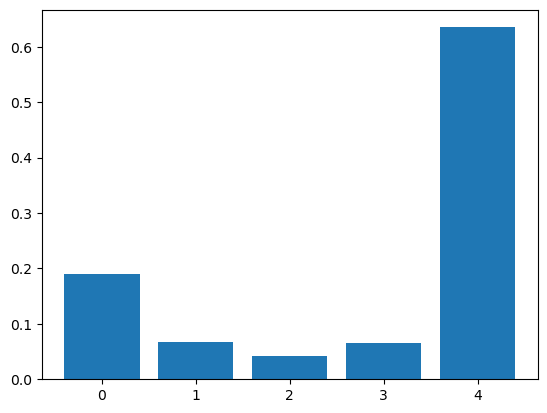

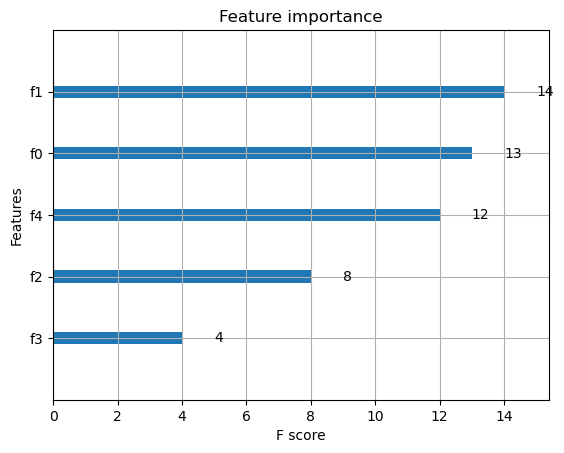

In [58]:
print(xgb.feature_importances_)
import matplotlib.pyplot as mp
mp.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
mp.show()

# plot feature importance
from xgboost import plot_importance
plot_importance(xgb)
mp.show()

In [59]:
dft = pd.read_csv("test.csv", index_col=0)
dft

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [60]:
le = LabelEncoder()
dft['Embarked'] = le.fit_transform(dft['Embarked'])
dft['Sex'] = le.fit_transform(dft['Sex'])
dft

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,1
893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,2
894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,1
895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,2
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,2
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",1,NaN,0,0,A.5. 3236,8.0500,NaN,2
1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,0
1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,2


In [61]:
dft = dft.apply(lambda col: LabelEncoder().fit_transform(dft["Embarked"]) if col.dtype == "object" else col)
dft.head(15)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,1,1,34.5,0,0,1,7.8292,1,1
893,3,2,0,47.0,1,0,2,7.0000,2,2
894,2,1,1,62.0,0,0,1,9.6875,1,1
895,3,2,1,27.0,0,0,2,8.6625,2,2
896,3,2,0,22.0,1,1,2,12.2875,2,2
897,3,2,1,14.0,0,0,2,9.2250,2,2
898,3,1,0,30.0,0,0,1,7.6292,1,1
899,2,2,1,26.0,1,1,2,29.0000,2,2
900,3,0,0,18.0,0,0,0,7.2292,0,0


In [62]:
# iterative imputation transform for the horse colic dataset
from numpy import isnan, mean, std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold 
from sklearn.pipeline import Pipeline
# load dataset
dft1 = dft.drop(columns={"Name","Cabin","Ticket"})
# split into input and output elements
data = dft1.values
ix = [i for i in range(data.shape[1]) if i != 9]
X, y = data[:, ix], data[:, 6]
# print total missing
print('Missing: %d' % sum(isnan(X).flatten()))
# define imputer
imputer = IterativeImputer()
#define modeling pipeline
model = XGBClassifier(use_label_encoder=False, base_score=0.25, booster='gbtree', eta=0.3, max_depth=4, min_child_weight=20,
                    max_delta_step=0.5, subsample=0.6, colsample_bytree=1, colsample_bylevel=0.7, colsample_bynode=1, 
                    reg_lambda=1, reg_alpha=1, tree_method="approx", sketch_eps=0.1, scale_pos_weight=1.6, 
                    objective="binary:logitraw", gamma=0, n_estimators=10, rate_drop="0.01", skip_drop="0.8",
                    random_state = 262)# fit on the dataset
imputer.fit(X)
# transform the dataset
dft1 = imputer.transform(X)
# print total missing
print('Missing: %d' % sum(isnan(dft1).flatten()))
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Missing: 87
Missing: 0
Mean Accuracy: 1.000 (0.000)


In [54]:
dft1 = dft.drop(columns={"Name","Cabin","Ticket"})
# split into input and output elements
data = dft1.values
ix = [i for i in range(data.shape[1]) if i != 9]
X, y = data[:, ix], data[:, 6]
# print total missing
print('Missing: %d' % sum(isnan(X).flatten()))
# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X)
# transform the dataset
dft1 = imputer.transform(X)
# print total missing
print('Missing: %d' % sum(isnan(dft1).flatten()))
dft1

Missing: 87


NameError: name 'KNNImputer' is not defined

In [63]:
dft1 = pd.DataFrame(dft1)
dft1

,0,1,2,3,4,5,6
0,3.0,1.0,34.500000,0.0,0.0,7.8292,1.0
1,3.0,0.0,47.000000,1.0,0.0,7.0000,2.0
2,2.0,1.0,62.000000,0.0,0.0,9.6875,1.0
3,3.0,1.0,27.000000,0.0,0.0,8.6625,2.0
4,3.0,0.0,22.000000,1.0,1.0,12.2875,2.0
...,...,...,...,...,...,...,...
413,3.0,1.0,25.224941,0.0,0.0,8.0500,2.0
414,1.0,0.0,39.000000,0.0,0.0,108.9000,0.0
415,3.0,1.0,38.500000,0.0,0.0,7.2500,2.0
416,3.0,1.0,25.224941,0.0,0.0,8.0500,2.0


In [64]:
dft1.columns = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]
dftnew = dft1[["Pclass","Age","Fare","Embarked","Sex"]]
print(dftnew.isnull().sum())
dftnew

Pclass      0
Age         0
Fare        0
Embarked    0
Sex         0
dtype: int64


,Pclass,Age,Fare,Embarked,Sex
0,3.0,34.500000,7.8292,1.0,1.0
1,3.0,47.000000,7.0000,2.0,0.0
2,2.0,62.000000,9.6875,1.0,1.0
3,3.0,27.000000,8.6625,2.0,1.0
4,3.0,22.000000,12.2875,2.0,0.0
...,...,...,...,...,...
413,3.0,25.224941,8.0500,2.0,1.0
414,1.0,39.000000,108.9000,0.0,0.0
415,3.0,38.500000,7.2500,2.0,1.0
416,3.0,25.224941,8.0500,2.0,1.0


In [65]:
dftnew1 = mmsc.fit_transform(dftnew)
dftnew1

array([[2.        , 0.90544639, 0.03056316, 1.        , 2.        ],
       [2.        , 1.23513121, 0.02732618, 2.        , 0.        ],
       [1.        , 1.630753  , 0.03781748, 1.        , 2.        ],
       ...,
       [2.        , 1.01094554, 0.02830212, 2.        , 2.        ],
       [2.        , 0.66081869, 0.03142511, 2.        , 2.        ],
       [2.        , 0.61260696, 0.08728099, 0.        , 2.        ]])

In [66]:
y_pred_xgb = pd.DataFrame(np.round(xgb.predict(dftnew1),0))
y_pred_xgb.to_csv("xgb_xgbimpute_fs2.csv")